# F - Clustering and Communities

In this notebook, we investigate clustering in our network by looking at structural communities, created using the Leiden community detection algorithm, and communities created based on categories. For both, we investigate modularity. We then compare these two to find whether they overlap. 

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests as rq
import pickle
import igraph as ig
import leidenalg
import seaborn as sns
from collections import defaultdict

First, we need to import the network.

In [2]:
url = "https://raw.githubusercontent.com/nicosrp/The-Architecture-of-Aspiration-A-Network-Perspective-on-Human-Goals/main/Networks/dayzero_network.pkl"
response = rq.get(url)
G = pickle.loads(response.content)

print(f"Network loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Network loaded: 2890 nodes, 219130 edges


Then, we need to extract the giant connected component we will be working with for the clustering.

In [3]:
# using only the giant connected component

components = list(nx.connected_components(G))
largest_cc = max(components, key=len)
Gcc = G.subgraph(largest_cc).copy()

### Communities Using the Leiden Algorithm

Communities in networks are groups of nodes more densely connected to each other than to nodes outside the group, forming distinct clusters. There are several algorithms available to identify communities. For our paper, we chose to use the Leiden community detection algorithm. The Leiden algorithm is based on the Louvain algorithm with certain added improvments, such as the gurantee that created communities will be connected. It also gurantees a partition in which all subsets of all communities are locally optimally assigned, and runs faster than the Louvain algorithm. In essence, it still works on adjusting partitions to maximize modularity. 

To use the algorithm, we make use of the igraph package. After creating the Leiden partition, we assign communities back to the nodes of our network for further analysis later on.

In [4]:
# Convert NetworkX → igraph
ig_graph = ig.Graph.from_networkx(Gcc)

# Ensure the node name attribute exists
ig_graph.vs["name"] = list(Gcc.nodes())

# Run Leiden
partition_leiden = leidenalg.find_partition(
    ig_graph,
    leidenalg.ModularityVertexPartition,
    weights="weight",
    seed=42    # ensures deterministic output
)

# Assign Leiden community back to NetworkX
for node, comm in zip(ig_graph.vs["name"], partition_leiden.membership):
    Gcc.nodes[node]["leiden_community"] = comm

In [5]:
num_comms_leiden = len(partition_leiden)
print("Number of Leiden communities:", num_comms_leiden)

Number of Leiden communities: 8


We find that the Leiden algorithm identifies eight distinct communities.

In [6]:
# List of community sizes
comm_sizes_leiden = [len(c) for c in partition_leiden]
for i, size in enumerate(comm_sizes_leiden):
    print(f"Community {i}: {size} nodes")

Community 0: 760 nodes
Community 1: 705 nodes
Community 2: 616 nodes
Community 3: 503 nodes
Community 4: 138 nodes
Community 5: 128 nodes
Community 6: 5 nodes
Community 7: 5 nodes


While six out of the eight communities contain more than 100 nodes each, the other two are very small with just five nodes contained in each.

In [7]:
# Compute modularity
leiden_modularity = partition_leiden.modularity
print("Leiden modularity:", leiden_modularity)

Leiden modularity: 0.24332171819896242


The Leiden partition reaches a modularity of around 0.24, indicating a moderately clear community structure.

### Communities Using the Created Categories

Next, we look at what happens when we use the categories we previously created as a basis for the partition of our network. 

First, we need to manually adjust the category classification of one entry, which was not classified in the prior process.

In [8]:
# fix category for read lolita
Gcc.nodes['Csz8rzLw']['category'] = "Media consumption" 

Now we can create communities based on the categories.

In [9]:
# Gcc is our giant connected component
category_comms = defaultdict(list)
for node, data in Gcc.nodes(data=True):
    cat = data.get("category")
    category_comms[cat].append(node)

# Convert to list of sets for modularity calculations
category_comms_sets = [set(nodes) for nodes in category_comms.values()]

To ensure this work correctly, we can look at the unique categories.

In [10]:
unique_categories = list(category_comms.keys())

print("Unique categories:", unique_categories)
print("Number of unique categories:", len(unique_categories))

Unique categories: ['Food', 'Acts of kindness/altruism', 'Experiences', 'Places of interest', 'Travel destinations', 'Health', 'Media consumption', 'Sports', 'Creativity', 'New skills', 'Relationships & social life', 'Nature', 'Academic and professional achievements', 'Religion', 'Events & concerts']
Number of unique categories: 15


To reiterate the division of nodes into these categories, we recall their distribution.

In [11]:
for cat, nodes in category_comms.items():
    print(f"{cat}: {len(nodes)} nodes")

Food: 96 nodes
Acts of kindness/altruism: 4 nodes
Experiences: 81 nodes
Places of interest: 863 nodes
Travel destinations: 999 nodes
Health: 17 nodes
Media consumption: 75 nodes
Sports: 45 nodes
Creativity: 6 nodes
New skills: 105 nodes
Relationships & social life: 8 nodes
Nature: 288 nodes
Academic and professional achievements: 2 nodes
Religion: 17 nodes
Events & concerts: 254 nodes


Now, we can calculate the modularity of this partition:

In [12]:
category_modularity = nx.algorithms.community.modularity(Gcc, category_comms_sets, weight="weight")
print("Category-based modularity:", category_modularity)

Category-based modularity: 0.06716598444702904


The category based community partition only reaches a modularity of around 0.07, which is very low and close to 0, indicating no meaningful community structure.

### Comparison of Leiden and Category Based Communities

To best be able to compare the assignment of nodes into communities using the two different ways described above, we use a heatmap to display overlap and differences.

In [13]:
# Get node attributes
leiden = nx.get_node_attributes(Gcc, "leiden_community")
categories = nx.get_node_attributes(Gcc, "category")

# Convert attributes to scalar values if needed
leiden = {n: (v[0] if isinstance(v, list) else v) for n, v in leiden.items()}

# Build DataFrame
full_communties_df = pd.DataFrame({
    "node": list(Gcc.nodes()),
    "leiden": [leiden.get(n, -1) for n in Gcc.nodes()],
    "category": [categories.get(n, "Unknown") for n in Gcc.nodes()]
})

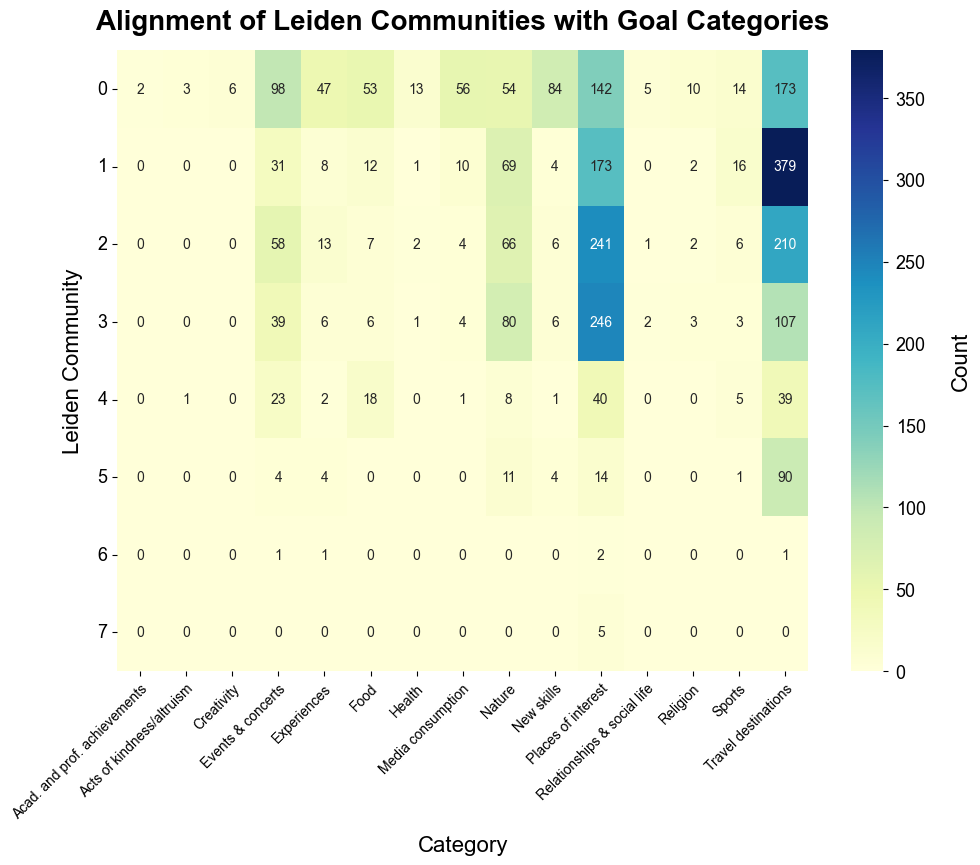

In [14]:
def compact_label(label):
    if label == 'Academic and professional achievements':
        return 'Acad. and prof. achievements'
    elif label == 'Relationships and social life':
        return 'Relationships and social'
    else:
        return label

plt.rcParams['font.family'] = 'Arial'

# Contingency table
heatmap_leiden = pd.crosstab(
    full_communties_df["leiden"],
    full_communties_df["category"]
)

# Apply compact labels to category column names
compact_cols = [compact_label(col) for col in heatmap_leiden.columns]
heatmap_leiden.columns = compact_cols

# Plot using PMI-like sizing but with exact sizes you requested
fig, ax = plt.subplots(figsize=(12, 9))
fig.subplots_adjust(bottom=0.25, left=0.23, right=0.95, top=0.94)

hm = sns.heatmap(heatmap_leiden, annot=True, fmt="d", cmap="YlGnBu", ax=ax)

# Apply requested exact sizes
ax.set_title('Alignment of Leiden Communities with Goal Categories', fontsize=20, pad=15, fontweight='bold')
ax.set_xlabel('Category', fontsize=16, labelpad=10)
ax.set_ylabel('Leiden Community', fontsize=16, labelpad=10)

# Category tick labels: set x labels to fontsize=10 (as requested); y labels remain 13
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=10)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=13)

# Colorbar label and padding set to requested size
cbar = hm.collections[0].colorbar
cbar.set_label('Count', fontsize=16, labelpad=18)
cbar.ax.tick_params(labelsize=13, pad=6)

plt.show()

The heatmap produced above shows that there is fairly little overlap between the structural communities and the category based ones. This supports what the difference in modularity score indicated. We can see that nodes contained in categories, such as travel destinations, are found in several different Leiden communities.